在学习这本教程的过程中(https://zh.d2l.ai/)

想要对House Prices这个数据集进行更多的尝试和探索。

在上一个titanic项目中，主要是使用sklearn结合特征工程。

这个项目将会关注各种神经网络在表格类数据的表现，以及特征对神经网络的影响


In [334]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
from torch.utils import data
from d2l import torch as d2l

In [335]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


In [336]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


首先需要选择特征，这里先不用常规的作图分析或者皮尔斯系数方法。
而是计算feature importance

In [337]:
#object对象类型一般是类别形变量，而int64和float64变量则是数据形
#需要将这两大类变量全部分开处理
#提取数值类特征
num_cols = train_data.loc[:,train_data.dtypes != 'object'].columns
num_train = train_data[num_cols]
#提取类别形数据
cat_cols = train_data.loc[:,train_data.dtypes == 'object'].columns
cat_train = train_data[cat_cols]

In [338]:
#先用Null替换数据中所有的空数据
tmp_df = train_data.copy()
tmp_df[cat_cols] = tmp_df[cat_cols].fillna('NULL')
# label encoding
for col in cat_cols:
    le = LabelEncoder()
    le.fit(tmp_df[col])
    tmp_df[col] = le.transform(tmp_df[col])
# train data
X_train = tmp_df.drop(['SalePrice', 'Id'], axis=1)
y_train = tmp_df['SalePrice']
lgb_train = lgb.Dataset(X_train, y_train)
params = {'objective': 'regression', 'metric': 'rmse'}
gbm = lgb.train(params, lgb_train)
# create DataFrame
cols = train_data.columns.drop(['Id', 'SalePrice'])
feat_importances = pd.DataFrame({'importance': gbm.feature_importance()}, index=X_train.columns).sort_values('importance', ascending=False)
feat_importances['dtype'] = ['numeric' if feat in num_cols else 'categorical' for feat in cols]
feat_importances

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3391
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 74
[LightGBM] [Info] Start training from score 180921.195890


,importance,dtype
GrLivArea,258,numeric
TotalBsmtSF,183,categorical
LotArea,181,numeric
BsmtFinSF1,165,numeric
GarageArea,150,categorical
...,...,...
MiscVal,0,numeric
Alley,0,numeric
Street,0,numeric
Utilities,0,categorical


In [339]:
feat_importances

,importance,dtype
GrLivArea,258,numeric
TotalBsmtSF,183,categorical
LotArea,181,numeric
BsmtFinSF1,165,numeric
GarageArea,150,categorical
...,...,...
MiscVal,0,numeric
Alley,0,numeric
Street,0,numeric
Utilities,0,categorical


特征选取的阈值没有明确理论，这里会进行多次实验，探索特征数量的影响。

In [340]:
selected_feature = feat_importances.loc[feat_importances['importance']>10]
selected_feature

,importance,dtype
GrLivArea,258,numeric
TotalBsmtSF,183,categorical
LotArea,181,numeric
BsmtFinSF1,165,numeric
GarageArea,150,categorical
1stFlrSF,144,categorical
MasVnrArea,138,categorical
LotFrontage,132,categorical
OpenPorchSF,112,categorical
GarageYrBlt,109,categorical


index_list表示所选取的特征

In [341]:
index_list = []
for i in selected_feature.index:
    index_list.append(i)
index_list

['GrLivArea',
 'TotalBsmtSF',
 'LotArea',
 'BsmtFinSF1',
 'GarageArea',
 '1stFlrSF',
 'MasVnrArea',
 'LotFrontage',
 'OpenPorchSF',
 'GarageYrBlt',
 'YearBuilt',
 'Neighborhood',
 'OverallQual',
 'YearRemodAdd',
 'BsmtUnfSF',
 '2ndFlrSF',
 'OverallCond',
 'WoodDeckSF',
 'MoSold',
 'SaleCondition',
 'BsmtExposure',
 'Exterior1st',
 'YrSold',
 'Condition1',
 'TotRmsAbvGrd',
 'BsmtFinType1',
 'FireplaceQu',
 'Fireplaces',
 'FullBath',
 'KitchenQual',
 'GarageCars',
 'MSSubClass',
 'GarageType',
 'BsmtQual',
 'GarageFinish',
 'ExterQual',
 'MSZoning',
 'EnclosedPorch',
 'HeatingQC',
 'LotConfig',
 'MasVnrType',
 'Functional',
 'ScreenPorch',
 'LotShape',
 'HouseStyle',
 'LandContour',
 'BedroomAbvGr',
 'Exterior2nd',
 'HalfBath',
 'BsmtFullBath']

接下来参考https://zh.d2l.ai/ 的做法构建线性模型

In [342]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


In [343]:
#获取全部特征列表
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [344]:
#只保留上面选取的特征
all_features = all_features[index_list]
all_features

,GrLivArea,TotalBsmtSF,LotArea,BsmtFinSF1,GarageArea,1stFlrSF,MasVnrArea,LotFrontage,OpenPorchSF,GarageYrBlt,...,MasVnrType,Functional,ScreenPorch,LotShape,HouseStyle,LandContour,BedroomAbvGr,Exterior2nd,HalfBath,BsmtFullBath
0,1710,856.0,8450,706.0,548.0,856,196.0,65.0,61,2003.0,...,BrkFace,Typ,0,Reg,2Story,Lvl,3,VinylSd,1,1.0
1,1262,1262.0,9600,978.0,460.0,1262,0.0,80.0,0,1976.0,...,None,Typ,0,Reg,1Story,Lvl,3,MetalSd,0,0.0
2,1786,920.0,11250,486.0,608.0,920,162.0,68.0,42,2001.0,...,BrkFace,Typ,0,IR1,2Story,Lvl,3,VinylSd,1,1.0
3,1717,756.0,9550,216.0,642.0,961,0.0,60.0,35,1998.0,...,None,Typ,0,IR1,2Story,Lvl,3,Wd Shng,0,1.0
4,2198,1145.0,14260,655.0,836.0,1145,350.0,84.0,84,2000.0,...,BrkFace,Typ,0,IR1,2Story,Lvl,4,VinylSd,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1092,546.0,1936,0.0,0.0,546,0.0,21.0,0,NaN,...,None,Typ,0,Reg,2Story,Lvl,3,CmentBd,1,0.0
1455,1092,546.0,1894,252.0,286.0,546,0.0,21.0,24,1970.0,...,None,Typ,0,Reg,2Story,Lvl,3,CmentBd,1,0.0
1456,1224,1224.0,20000,1224.0,576.0,1224,0.0,160.0,0,1960.0,...,None,Typ,0,Reg,1Story,Lvl,4,VinylSd,0,1.0
1457,970,912.0,10441,337.0,0.0,970,0.0,62.0,32,NaN,...,None,Typ,0,Reg,SFoyer,Lvl,3,Wd Shng,0,0.0


In [345]:
number_features = len(all_features.columns)
number_features

50

In [346]:
#数据预处理，数值类数据
#获取数值类数据
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
#所有数据整体进行归一化，减去均值除方差
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
#缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [347]:
#数据预处理，类别类数据
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指⽰符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape


(2919, 199)

预处理是将训练集和测试集一起处理的，然后这里进行分离
将刚刚的总体特征all_features拆解
得到train_features(训练集特征),test_features(测试集特征),train_label(训练标签)

In [348]:
n_train = train_data.shape[0]
print(n_train)
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

1460


训练一个带有损失平方的线性函数，适合作为基准模型。

这里构建最简单的非线性模型，也就是教材的基础上，将线性层后加一个relu


In [349]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
print(in_features)
def get_net():
    net = nn.Sequential(nn.Linear(in_features,1),nn.ReLU())
    return net

199


In [350]:
#对于预测房价和真实房价的差距，这里关心的是对数误差
def log_rmse(net, features, labels):
    # 为了在取对数时进⼀步稳定该值，将⼩于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
    return rmse.item()

In [351]:
#python数据迭代器，我们将features和labels作为API的参数传递，并通过数据迭代器指定batch_size。
#此外，布尔值is_train表⽰是否希望数据迭代器对象在每个迭代周期内打乱数据。
def load_array(data_arrays, batch_size, is_train=True): #@save
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [352]:
def train(net, train_features, train_labels, test_features, test_labels,
            num_epochs, learning_rate, weight_decay, batch_size):
    #train_ls和test_ls存储每个epoch的loss情况
    train_ls, test_ls = [], []
    train_iter = load_array((train_features, train_labels), batch_size)
    # 这⾥使⽤的是Adam优化算法，定义优化器
    optimizer = torch.optim.Adam(net.parameters(),lr = learning_rate,weight_decay = weight_decay)
    #对于每个epoch的训练
    for epoch in range(num_epochs):
        for X, y in train_iter:
            #grad每次开始前需要置0
            optimizer.zero_grad()
            #计算loss
            l = loss(net(X), y)
            #反向传播
            l.backward()
            optimizer.step()
        #使用log_rmse衡量本次epoch的loss结果
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls


定义K折交叉验证函数，来评估结果

In [353]:
#我们⾸先需要定义⼀个函数，在K折交叉验证过程中返回第i折的数据。具体地说，它选择第i个切⽚作为
#验证数据，其余部分作为训练数据。注意，这并不是处理数据的最有效⽅法，如果我们的数据集⼤得多，会
#有其他解决办法。

def get_k_fold_data(k, i, X, y):
    assert k > 1
    #定义每一折的大小
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    #对于每一折
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid


In [354]:
#K折交叉验证函数
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
            batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        #获取第K折的数据，data实际上表示X_train, y_train, X_valid, y_valid
        data = get_k_fold_data(k, i, X_train, y_train)
        #获取网络
        net = get_net()
        #注意train函数net参数之后需要接受train_features, train_labels, test_features, test_labels
        #这里用*data表示接受多个参数
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                    weight_decay, batch_size)
        #每一折的loss都会累加给train_l_sum，最后用来返回平均loss
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                    xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                    legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
                    f'验证log rmse{float(valid_ls[-1]):f}')
    #返回k折交叉验证的平均train loss和valid loss
    return train_l_sum / k, valid_l_sum / k

通过K折交叉验证来评价当前的模型

保留特征数量 : 50
折1，训练log rmse0.448813, 验证log rmse0.303780
折2，训练log rmse0.314544, 验证log rmse0.691646
折3，训练log rmse0.431682, 验证log rmse0.318529
折4，训练log rmse0.441132, 验证log rmse0.342933
折5，训练log rmse0.438533, 验证log rmse0.323002
5-折验证: 平均训练log rmse: 0.414941, 平均验证log rmse: 0.395978


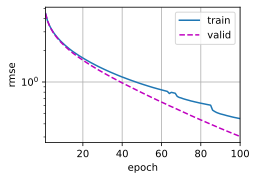

In [355]:
print("保留特征数量 :",number_features)

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
    f'平均验证log rmse: {float(valid_l):f}')


In [356]:
#成功验证之后，就可以将全部训练集数据拿来进行训练并预测测试集
def train_and_pred(train_features, test_features, train_labels, test_data,
                    num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
            ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将⽹络应⽤于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.162514


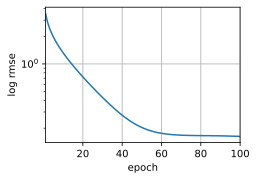

In [306]:
train_and_pred(train_features, test_features, train_labels, test_data,
num_epochs, lr, weight_decay, batch_size)